In [2]:
from bs4 import BeautifulSoup
import requests
import wget
import datetime as dt

MAIN_PAGE = "https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports"
html = requests.get(MAIN_PAGE)
soup = BeautifulSoup(html.content)
all_links = [link.get("href") for link in soup("a")]
pdf_links = list(set(filter(lambda x: ".pdf" in x, all_links)))
ROOT_URL = "https://www.who.int"
for pdf_link in pdf_links:
    pdf_url = "%s%s" % (ROOT_URL, pdf_link)
    print("-> getting", pdf_url)
    wget.download(pdf_url)

-> getting https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200208-sitrep-19-ncov.pdf?sfvrsn=6e091ce6_4
-> getting https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200201-sitrep-12-ncov.pdf?sfvrsn=273c5d35_2
-> getting https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200209-sitrep-20-ncov.pdf?sfvrsn=6f80d1b9_4
-> getting https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200203-sitrep-14-ncov.pdf?sfvrsn=f7347413_4
-> getting https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200211-sitrep-22-ncov.pdf?sfvrsn=fb6d49b1_2
-> getting https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200124-sitrep-4-2019-ncov.pdf?sfvrsn=9272d086_8
-> getting https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200225-sitrep-36-covid-19.pdf?sfvrsn=2791b4e0_2
-> getting https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200129-sitre

In [3]:
import glob
import tabula

all_reports = glob.glob("*.pdf")

all_dfs = {}
for report in all_reports:
    print("-> processing", report)
    dfs = tabula.read_pdf(report, pages="all")
    dt = report[:8]
    all_dfs[dt] = dfs

Box and will be ignored
Mar 01, 2020 11:42:26 AM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font BCDGEE+Calibri-Bold are not implemented in PDFBox and will be ignored
Mar 01, 2020 11:42:26 AM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font BCDHEE+Calibri are not implemented in PDFBox and will be ignored
Mar 01, 2020 11:42:26 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Mar 01, 2020 11:42:27 AM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font Arial-BoldMT are not implemented in PDFBox and will be ignored
Mar 01, 2020 11:42:27 AM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font BCDGEE+Calibri-Bold are not implemented in PDFBox and will be ignored
Mar 01, 2020 11:42:27 AM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font BCDHEE+Calibri are not impleme

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from tabulate import tabulate

sorted_keys = sorted(all_dfs.keys())

In [191]:
'''
Tabella per Cina:

Struttura finale ['Report Date', 'Total Cases', 'Total Deaths']
'''
search_region = 'Henan'
cina_series = []
for key in ['20200229']:#sorted_keys:
    rep_date = dt.datetime.strptime(key,"%Y%m%d")
    print("-> processing Cina data for: %s" % rep_date)
    for tbl in all_dfs[key]:
        print(tbl)
        if search_region in tbl.values:
            ncols = tbl.shape[1]
            cols = {}
            for (i,k) in enumerate(tbl.columns):
                cols[k] = ('Unnamed: %d' % i)
            rtbl = tbl.rename(columns=cols)
            print(tabulate(rtbl, headers='keys', tablefmt='psql'))

-> processing Cina data for: 2020-02-29 00:00:00
   Coronavirus disease 2019 (COVID-19)\r\rSituation Report – 40
0                                                NaN           
1                                                NaN           
   HIGHLIGHTS\r\r•Two new Member States (Mexico and San Marino) reported cases of COVID-\r19 in the past 24 hours.\r\r•WHO has published the Rational use of personal protective equipment for\rCOVID-19.ThisdocumentsummarizesWHOrecommendationsforthe\rappropriate use of personal protective equipment (PPE) in health care and\rcommunity settings, including the handling of cargo. More information on\rInfection Prevention and Control (IPC) activities can be found in the Subject in\rFocus.  \
0                                                NaN                                                                                                                                                                                                                         

In [9]:

'''
Tabelle per paese esterno a Cina:

Struttura finale dati: ['Report Date', 'Country', 'Total Cases', 'Total deaths']
'''
search_country = 'Italy'
country_series = []
for key in sorted_keys:
  rep_date = dt.datetime.strptime(key,"%Y%m%d")
  print("-> processing Country data for: %s" % rep_date)
  for tbl in all_dfs[key]:
    if search_country in tbl.values:
      ncols = tbl.shape[1] # must be in [3, 5, 6, 7]
      cols = {}
      for (i,k) in enumerate(tbl.columns):
        cols[k] = ('Unnamed: %d' % i)
      rtbl = tbl.rename(columns=cols)
      if False:
        print(tabulate(rtbl, headers='keys', tablefmt='psql'))
      elif int(key) >= 20200228:
        country_col_name = 'Unnamed: 0'
        ftbl = rtbl.dropna(subset=[country_col_name])
        otbl = pd.DataFrame(
            {
                'Report Date' : [rep_date for i in range(ftbl.shape[0])],
                'Country' : ftbl[country_col_name],
                'Total Cases' : ftbl['Unnamed: 1'].str.split('(', expand = True)[0],
                'Total Deaths' : ftbl['Unnamed: 2'].str.split('(', expand = True)[0]
            }
        )
      elif int(key) >= 20200221:
        country_col_name = 'Unnamed: 0'
        ftbl = rtbl.dropna(subset=[country_col_name])
        last_idx = ftbl.shape[1]
        last_col = 'Unnamed: %d' % (last_idx-1)
        otbl = pd.DataFrame(
            {
                'Report Date' : [rep_date for i in range(ftbl.shape[0])],
                'Country' : ftbl[country_col_name],
                'Total Cases' : ftbl['Unnamed: 1'].str.split('(', expand = True)[0],
                'Total Deaths' : ftbl[last_col].str.split('(', expand = True)[0]
            }
        )        

      elif int(key) >= 20200214:
        country_col_name = 'Unnamed: 0'
        ftbl = rtbl.dropna(subset=[country_col_name])
        otbl = pd.DataFrame(
            {
                'Report Date' : [rep_date for i in range(ftbl.shape[0])],
                'Country' : ftbl[country_col_name],
                'Total Cases' : ftbl['Unnamed: 2'].str.split('(', expand = True)[0],
                'Total Deaths' : ftbl['Unnamed: 6'].str.split('(', expand = True)[0]
            }
        )        
      elif int(key) >= 20200210:
        country_col_name = 'Unnamed: 1'
        ftbl = rtbl.dropna(subset=[country_col_name])
        otbl = pd.DataFrame(
            {
                'Report Date' : [rep_date for i in range(ftbl.shape[0])],
                'Country' : ftbl[country_col_name],
                'Total Cases' : ftbl['Unnamed: 2'].str.split('(', expand = True)[0],
                'Total Deaths' : ftbl['Unnamed: 5'].str.split('(', expand = True)[0]
            }
        )        
      elif int(key) >= 20200207:
        country_col_name = 'Unnamed: 1'
        ftbl = rtbl.dropna(subset=[country_col_name])
        otbl = pd.DataFrame(
            {
                'Report Date' : [rep_date for i in range(ftbl.shape[0])],
                'Country' : ftbl[country_col_name],
                'Total Cases' : ftbl['Unnamed: 2'].str.split('(', expand = True)[0],
                'Total Deaths' : ftbl['Unnamed: 6'].str.split('(', expand = True)[0]
            }
        )        
      elif int(key) >= 20200206:
        country_col_name = 'Unnamed: 0'
        ftbl = rtbl.dropna(subset=[country_col_name])
        otbl = pd.DataFrame(
            {
                'Report Date' : [rep_date for i in range(ftbl.shape[0])],
                'Country' : ftbl[country_col_name],
                'Total Cases' : ftbl['Unnamed: 2'].str.split('(', expand = True)[0],
                'Total Deaths' : ftbl['Unnamed: 6'].str.split('(', expand = True)[0]
            }
        )
      elif int(key) >= 20200203:
        country_col_name = 'Unnamed: 1'
        ftbl = rtbl.dropna(subset=[country_col_name])
        otbl = pd.DataFrame(
            {
                'Report Date' : [rep_date for i in range(ftbl.shape[0])],
                'Country' : ftbl[country_col_name],
                'Total Cases' : ftbl['Unnamed: 2'].str.split(' ', expand = True)[0],
                'Total Deaths' : ftbl['Unnamed: 4'].str.split(' ', expand = True)[0]
            }
        )
      else:
        country_col_name = 'Unnamed: 1'
        ftbl = rtbl.dropna(subset=[country_col_name])
        otbl = pd.DataFrame(
            {
                'Report Date' : [rep_date for i in range(ftbl.shape[0])],
                'Country' : ftbl[country_col_name],
                'Total Cases' : ftbl['Unnamed: 2'],
                'Total Deaths' : [np.nan for i in range(ftbl.shape[0])]
            }
        )
      country_series.append(otbl)

-> processing report date: 2020-01-21 00:00:00
-> processing report date: 2020-01-22 00:00:00
-> processing report date: 2020-01-23 00:00:00
-> processing report date: 2020-01-24 00:00:00
-> processing report date: 2020-01-25 00:00:00
-> processing report date: 2020-01-26 00:00:00
-> processing report date: 2020-01-27 00:00:00
-> processing report date: 2020-01-28 00:00:00
-> processing report date: 2020-01-29 00:00:00
-> processing report date: 2020-01-30 00:00:00
-> processing report date: 2020-01-31 00:00:00
-> processing report date: 2020-02-01 00:00:00
-> processing report date: 2020-02-02 00:00:00
-> processing report date: 2020-02-03 00:00:00
-> processing report date: 2020-02-04 00:00:00
-> processing report date: 2020-02-05 00:00:00
-> processing report date: 2020-02-06 00:00:00
-> processing report date: 2020-02-07 00:00:00
-> processing report date: 2020-02-08 00:00:00
-> processing report date: 2020-02-09 00:00:00
-> processing report date: 2020-02-10 00:00:00
-> processing

In [182]:
country_series_dset = pd.concat(country_series)
country_series_dset['Total Cases'] = pd.to_numeric(country_series_dset['Total Cases'],errors='coerce')
country_series_dset['Total Deaths'] = pd.to_numeric(country_series_dset['Total Deaths'],errors='coerce')
country_series_dset['Mortality Rate'] = country_series_dset['Total Deaths'] / country_series_dset['Total Cases']
country_series_dset.dropna(inplace=True)

In [183]:
n_top = 6
last_report_date = country_series_dset['Report Date'].max()
last_series = country_series_dset.loc[country_series_dset['Report Date'] == last_report_date,:]
top_worst = last_series.sort_values(by='Total Cases', ascending=False).head(n_top)
print(tabulate(top_worst, headers='keys', tablefmt='psql'))
top_countries = list(top_worst.Country.unique())

+----+---------------------+----------------------------+---------------+----------------+------------------+
|    | Report Date         | Country                    |   Total Cases |   Total Deaths |   Mortality Rate |
|----+---------------------+----------------------------+---------------+----------------+------------------|
|  3 | 2020-02-29 00:00:00 | Republic of Korea          |          3150 |             17 |       0.00539683 |
| 13 | 2020-02-29 00:00:00 | Italy                      |           888 |             21 |       0.0236486  |
| 43 | 2020-02-29 00:00:00 | Iran (Islamic Republic of) |           388 |             34 |       0.0876289  |
|  4 | 2020-02-29 00:00:00 | Japan                      |           230 |              5 |       0.0217391  |
|  5 | 2020-02-29 00:00:00 | Singapore                  |            98 |              0 |       0          |
| 14 | 2020-02-29 00:00:00 | Germany                    |            57 |              0 |       0          |
+----+----

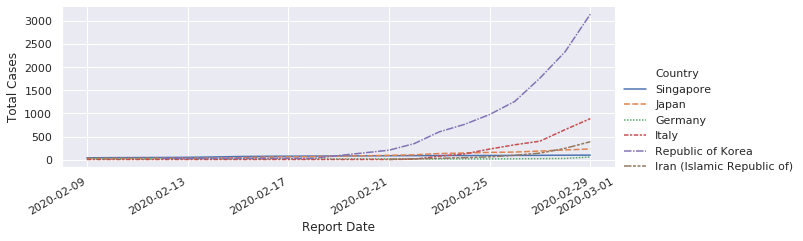

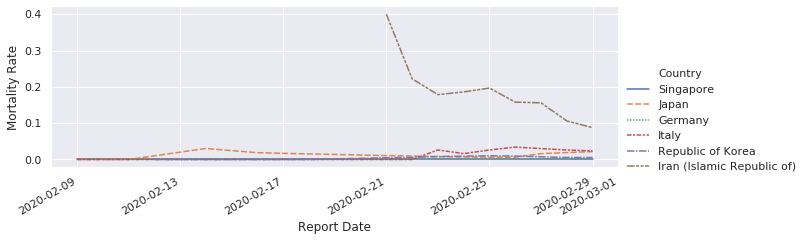

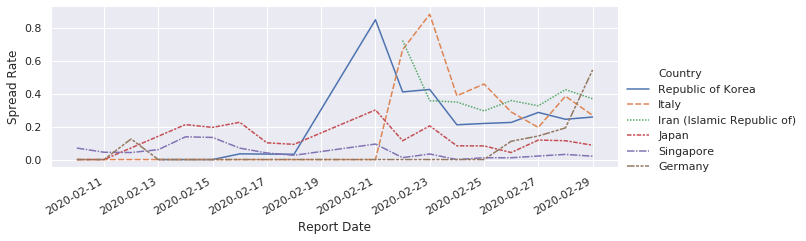

In [184]:
import seaborn as sns
sns.set(style="darkgrid")
cutoff_date = dt.datetime(2020,2,9)
country_subset = \
    country_series_dset.loc[(country_series_dset.Country.isin(top_countries)) & (country_series_dset['Report Date'] >= cutoff_date),:]
spread_rate_list = []
for the_country in top_countries:
    f_country = country_series_dset.loc[(country_series_dset.Country == the_country) & (country_series_dset['Report Date'] >= cutoff_date),:]
    f_country['New Cases'] = f_country.loc[:,['Total Cases']].diff()['Total Cases'].to_numpy()
    f_country['Spread Rate'] = f_country['New Cases'] / f_country['Total Cases']
    spread_rate_list.append(f_country)
spread_rate_dset = pd.concat(spread_rate_list)
# Plots
p_totcases = sns.relplot(x='Report Date', y='Total Cases', kind='line', hue='Country', style='Country', data=country_subset,
                height=3, aspect=3) 
p_totcases.fig.autofmt_xdate()
p_mrate = sns.relplot(x='Report Date', y='Mortality Rate', kind='line', hue='Country', style='Country', data=country_subset,
                 height=3, aspect=3) 
p_mrate.fig.autofmt_xdate()
p_srate = sns.relplot(x='Report Date', y='Spread Rate', kind='line', hue='Country', style='Country', data=spread_rate_dset,
                 height=3, aspect=3) 
p_srate.fig.autofmt_xdate()